In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
os.getcwd()


'/home/riccardo/WORK-RESEARCH/MirrorRL'

# MirrorRL

<AxesSubplot:xlabel='time_total_s'>

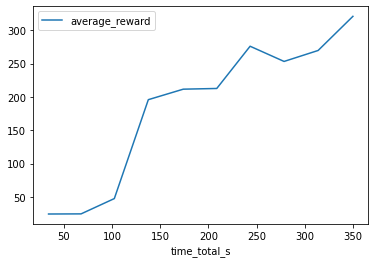

In [55]:
df = pd.read_csv("ray_results/run_2022-05-13_17-28-00/run_4626c_00000_0_batch_size=64,eta=0.12036,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,n_2022-05-13_17-28-01/progress.csv")
df.plot(x="time_total_s", y="average_reward")

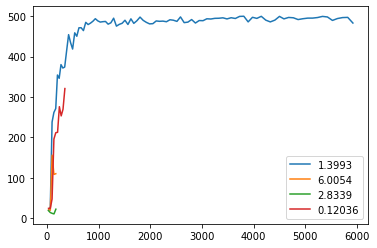

In [58]:
def plot(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    for f in all_folders:
        data = pd.read_csv(path+f+"/progress.csv")
        fig = plt.figure(0)
        if limsup != None:
            data = data[data["time_total_s"]<limsup]
        labels = f.split(",")
        eta = labels[1][4:]
        # "time_total_s" "average_reward" "q_error_train" "kl" "entropy"
        plt.plot(data["time_total_s"], data["average_reward"], label=eta)
    plt.legend()
    plt.show()

path = "ray_results/run_2022-05-13_17-28-00/"
plot(path,6000)

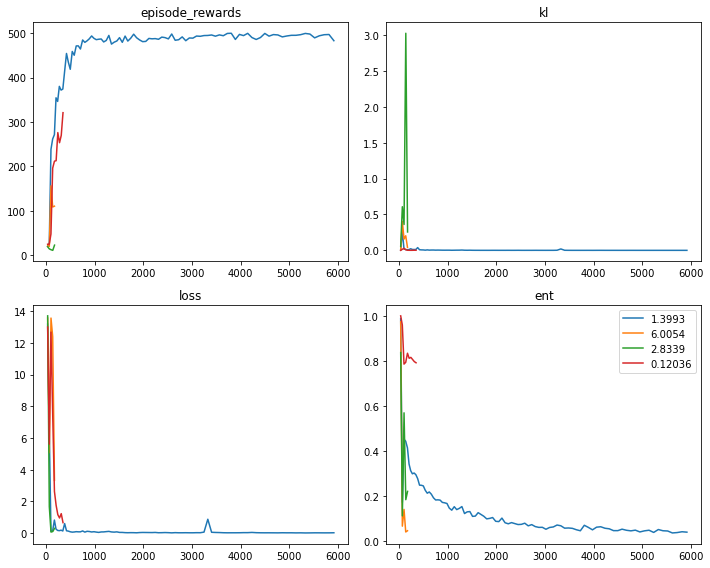

In [246]:
def plot_all(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    for f in all_folders:
        df = pd.read_csv(path+f+"/progress.csv")
        if limsup != None:
            df = df[df["time_total_s"]<limsup]
        # extract eta 
        labels = f.split(",")
        eta = labels[1][4:]
        # 
        axs[0, 0].plot(df["time_total_s"], df["average_reward"], label=eta)
        axs[0, 0].set_title("episode_rewards")
        axs[1, 0].plot(df["time_total_s"], df["q_error_train"], label=eta)
        axs[1, 0].set_title("loss")
        axs[0, 1].plot(df["time_total_s"], df["kl"], label=eta)
        axs[0, 1].set_title("kl")
        axs[1, 1].plot(df["time_total_s"], df["entropy"], label=eta)
        axs[1, 1].set_title("ent")
    plt.legend()
    fig.tight_layout()

path = "ray_results/run_2022-05-13_17-28-00/"
plot_all(path,6000)

# A2C and DQN
be careful with following code: if you change batch size for example it does not work anymore

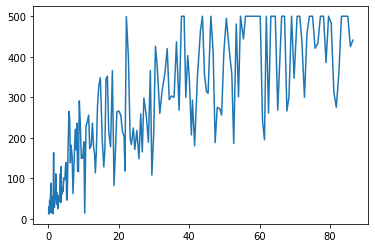

In [250]:
df = pd.read_csv("results/solving_cartpole/solving_cartpole/1/manager_data/data.csv")
df["n"] = range(0, len(df))
s1 = (df["tag"]!="dw_time_elapsed") & (df["global_step"]%5==0)
s2 = (df["tag"]=="dw_time_elapsed") & ((df["global_step"]%5==0) & (df["n"]%4==0))
df = df[s1 | s2]
df = df.pivot(index= "global_step", columns="tag", values="value")
plt.plot(df["dw_time_elapsed"], df["episode_rewards"])

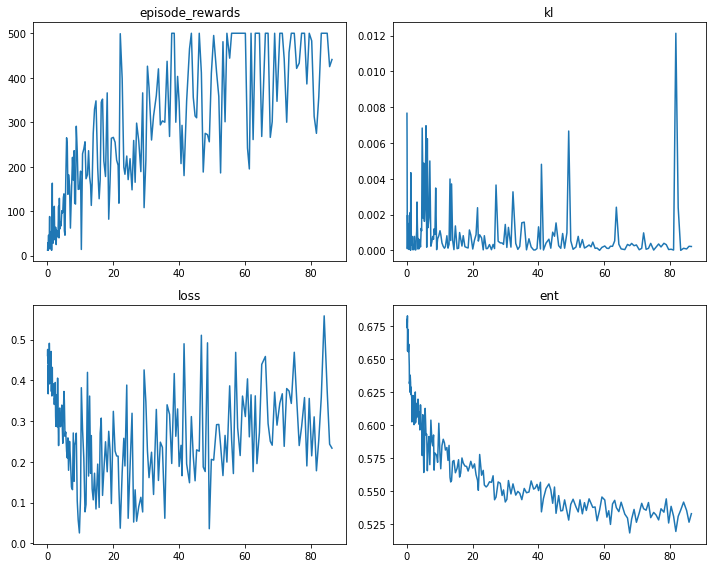

In [251]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0, 0].plot(df["dw_time_elapsed"], df["episode_rewards"])
axs[0, 0].set_title("episode_rewards")
axs[1, 0].plot(df["dw_time_elapsed"], df["loss"])
axs[1, 0].set_title("loss")
axs[0, 1].plot(df["dw_time_elapsed"], df["kl"])
axs[0, 1].set_title("kl")
axs[1, 1].plot(df["dw_time_elapsed"], df["ent"])
axs[1, 1].set_title("ent")
fig.tight_layout()